# Hack&Change 2025

## Трек: Альфа-банк
## Команда: Polar Express

**Прогноз дохода клиентов банка**

В этом ноутбуке выполняется полный цикл работы с данными для задачи прогнозирования дохода клиентов банка:
- загружаем и изучаем обучающую и тестовую выборки;
- проводим очистку данных и построение признаков;
- обучаем модель градиентного бустинга для минимизации метрики WMAE;
- считаем дополнительные метрики качества и делаем выводы;
- анализируем важность признаков с помощью SHAP и готовим артефакты для последующей интеграции в FastAPI и Streamlit-интерфейс.

### Импорт библиотек

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
from itertools import product
from lightgbm import LGBMRegressor
import shap
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

WMAE

In [4]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return (weights * np.abs(y_true - y_pred)).mean()

### Загрузка данных

In [5]:
train_df = pd.read_csv('hackathon_income_train.csv', decimal=',', sep=';')
test_df  = pd.read_csv('hackathon_income_test.csv',  decimal=',', sep=';')

print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

Train shape: (76786, 224)
Test shape : (73214, 222)


In [6]:
train_df.head()

,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,109324.476325,1465144.960,NaN,52800.0,365346.244634,23213.0,97366.0,Женский,...,1.0,0.0,57.0,0.0,297.0,0.027027,9.0,NaN,0.301217,NaN
1,4,2024-02-29,25558.028662,303593.660,NaN,260200.0,NaN,10000.0,32580.0,Женский,...,NaN,0.0,707.0,67.0,30245.0,NaN,2.0,NaN,0.695800,NaN
2,5,2024-02-29,40666.753098,490754.010,NaN,2000000.0,NaN,90000.0,96866.0,Женский,...,NaN,422.0,0.0,0.0,210322.0,0.000000,20.0,NaN,0.515970,NaN
3,6,2024-04-30,43856.672058,219875.120,NaN,75000.0,NaN,75000.0,43860.0,Мужской,...,NaN,0.0,0.0,0.0,7187.0,0.000000,7.0,NaN,0.478003,NaN
4,7,2024-04-30,130420.851992,1750241.845,NaN,1000000.0,NaN,240000.0,83815.0,Женский,...,NaN,0.0,84.0,0.0,690038.0,0.000000,9.0,NaN,0.552314,NaN


### Первичный анализ данных

In [7]:
features_desc = pd.read_csv("features_description.csv", sep=";", encoding="windows-1251")

print("Описание признаков")
display(features_desc.head())

Описание признаков


,признак,описание
0,dt,Дата актуальности признаков
1,target,таргет
2,turn_cur_cr_avg_act_v2,Средний текущий кредитовый оборот по текущим с...
3,salary_6to12m_avg,Усреднённая ЗП клиента за окно в минимум 6 мес...
4,hdb_bki_total_max_limit,БКИ: Максимальный кредитный лимит по любому пр...


In [8]:
print(" Общая информация о train ")
display(train_df.head())
print("\ntrain_df.info():")
print(train_df.info())

 Общая информация о train 


,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,109324.476325,1465144.960,NaN,52800.0,365346.244634,23213.0,97366.0,Женский,...,1.0,0.0,57.0,0.0,297.0,0.027027,9.0,NaN,0.301217,NaN
1,4,2024-02-29,25558.028662,303593.660,NaN,260200.0,NaN,10000.0,32580.0,Женский,...,NaN,0.0,707.0,67.0,30245.0,NaN,2.0,NaN,0.695800,NaN
2,5,2024-02-29,40666.753098,490754.010,NaN,2000000.0,NaN,90000.0,96866.0,Женский,...,NaN,422.0,0.0,0.0,210322.0,0.000000,20.0,NaN,0.515970,NaN
3,6,2024-04-30,43856.672058,219875.120,NaN,75000.0,NaN,75000.0,43860.0,Мужской,...,NaN,0.0,0.0,0.0,7187.0,0.000000,7.0,NaN,0.478003,NaN
4,7,2024-04-30,130420.851992,1750241.845,NaN,1000000.0,NaN,240000.0,83815.0,Женский,...,NaN,0.0,84.0,0.0,690038.0,0.000000,9.0,NaN,0.552314,NaN



train_df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76786 entries, 0 to 76785
Columns: 224 entries, id to first_salary_income
dtypes: float64(182), int64(1), object(41)
memory usage: 131.2+ MB
None


В train 76k строк и 224 признака, из них 182 числовых и 41 категориальный

In [9]:
print(" Проверка пропусков ")
missing_train = train_df.isna().sum().sort_values(ascending=False)
print(missing_train.head(20))

 Проверка пропусков 
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet            75589
turn_fdep_db_avg_act_v2                                                                  74461
turn_fdep_db_avg_v2                                                                      72950
turn_fdep_db_sum_v2                                                                      72950
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete                 71564
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii    71218
dp_payoutincomedata_payout_avg_prev_year                                                 68915
first_salary_income                                                                      68118
avg_by_category__amount__sum__cashflowcategory_name__oteli                               67925
by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu                 67700
avg_by_category__amount__sum_

По пропускам видно, что часть фич сильно разрежены, так что нужно будет  продумать , как заполнять или отбирать признаки

In [10]:
print(" Типы данных и базовая статистика по target и w ")
print("Target describe:")
print(train_df["target"].describe().apply(lambda x: f"{x:.2f}"))
print("\nWeights (w) describe:")
print(train_df["w"].describe())

 Типы данных и базовая статистика по target и w 
Target describe:
count      76786.00
mean       92648.24
std       112408.98
min        20000.00
25%        39709.97
50%        62754.13
75%       100201.68
max      1500000.00
Name: target, dtype: object

Weights (w) describe:
count    76786.000000
mean         0.569014
std          0.551835
min          0.000021
25%          0.235950
50%          0.449424
75%          0.680337
max          2.570703
Name: w, dtype: float64


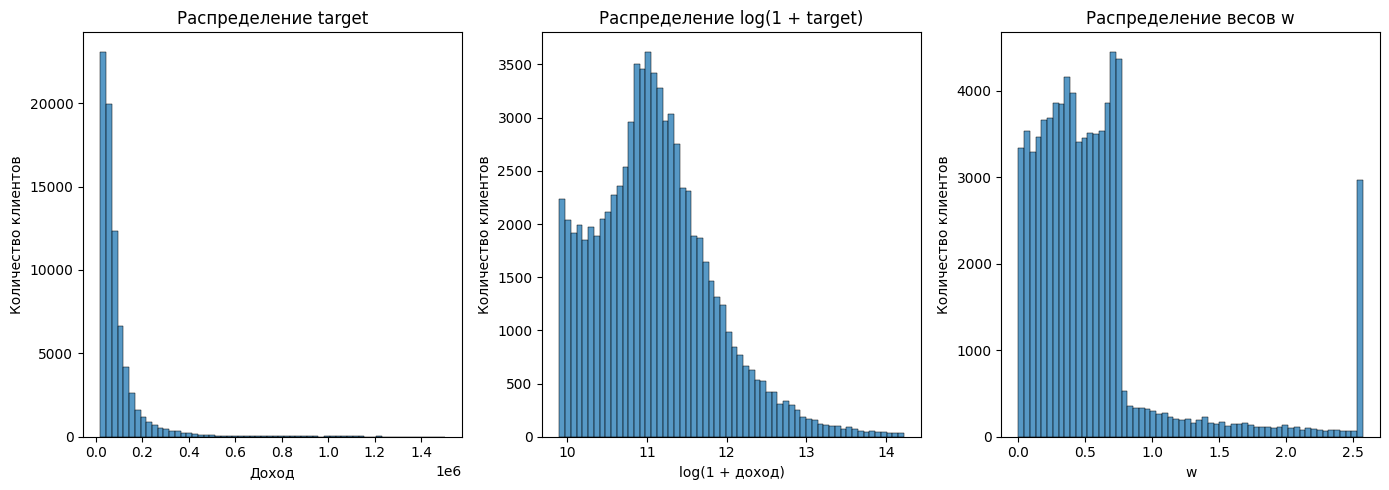

In [11]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_df["target"], bins=60, kde=False)
plt.title("Распределение target")
plt.xlabel("Доход")
plt.ylabel("Количество клиентов")

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(train_df["target"]), bins=60, kde=False)
plt.title("Распределение log(1 + target)")
plt.xlabel("log(1 + доход)")
plt.ylabel("Количество клиентов")

plt.subplot(1, 3, 3)
sns.histplot(train_df["w"], bins=60, kde=False)
plt.title("Распределение весов w")
plt.xlabel("w")
plt.ylabel("Количество клиентов")

plt.tight_layout()
plt.show()

По `target` и `w` вместе: таргет распределён сильно неоднородно — медианный доход около 63 тыс., но при этом есть длинный хвост до 1.5 млн и высокая дисперсия, так что модель будет одновременно видеть и массовый сегмент со средними доходами, и редких высокодоходных клиентов. Одновременно веса лежат примерно в диапазоне от почти нуля до 2.57, со средним около 0.57, что значит, что при расчёте основной метрики *WMAE* разные клиенты имеют существенно разную «цену ошибки», и при обучении нужно передавать веса, чтобы качество максимально соответствовало бизнес-приоритетам банка

In [12]:
# Выделим числовые и категориальные признаки
exclude_cols = ["id", "target", "w", "dt"]
num_cols = train_df.select_dtypes(include=["float64", "int64"]).columns.difference(exclude_cols)
cat_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

print(f"Числовых признаков: {len(num_cols)}")
print(f"Категориальных признаков: {len(cat_cols)}")
print("Категориальные примеры:", cat_cols[:10])

print("\nПервые 10 признаков по количеству пропусков среди числовых:")
print(train_df[num_cols].isna().sum().sort_values(ascending=False).head(10))

print("\nПервые 10 признаков по количеству пропусков среди категориальных:")
print(train_df[cat_cols].isna().sum().sort_values(ascending=False).head(10))

Числовых признаков: 180
Категориальных признаков: 41
Категориальные примеры: ['dt', 'hdb_bki_total_max_limit', 'hdb_bki_total_cc_max_limit', 'gender', 'adminarea', 'hdb_bki_total_pil_max_limit', 'hdb_bki_active_cc_max_limit', 'city_smart_name', 'hdb_bki_other_active_pil_outstanding', 'dp_ewb_last_employment_position']

Первые 10 признаков по количеству пропусков среди числовых:
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet            75589
turn_fdep_db_avg_act_v2                                                                  74461
turn_fdep_db_avg_v2                                                                      72950
turn_fdep_db_sum_v2                                                                      72950
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete                 71564
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii    71218
dp_payoutincomedata_payout_avg_prev_year         

In [13]:
# Доли пропусков по всем признакам
na_frac = train_df.isna().mean().sort_values(ascending=False)

print("Топ30 признаков по доле пропусков:")
display(na_frac.head(30))

# Списки кандидатов на дроп по порогам 0.8 и 0.9
high_na_80 = na_frac[na_frac > 0.8].index.tolist()
high_na_90 = na_frac[na_frac > 0.9].index.tolist()

print(f"\nПризнаков с пропусками > 80%: {len(high_na_80)}")
print(f"Признаков с пропусками > 90%: {len(high_na_90)}")

print("\nПримеры (80%+):", high_na_80[:15])

Топ30 признаков по доле пропусков:


,0
avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet,0.984411
turn_fdep_db_avg_act_v2,0.969721
turn_fdep_db_avg_v2,0.950043
turn_fdep_db_sum_v2,0.950043
avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete,0.931993
avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii,0.927487
dp_payoutincomedata_payout_avg_prev_year,0.897494
first_salary_income,0.887115
avg_by_category__amount__sum__cashflowcategory_name__oteli,0.884601
by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu,0.881671



Признаков с пропусками > 80%: 33
Признаков с пропусками > 90%: 6

Примеры (80%+): ['avg_by_category__amount__sum__cashflowcategory_name__platezhi_cherez_internet', 'turn_fdep_db_avg_act_v2', 'turn_fdep_db_avg_v2', 'turn_fdep_db_sum_v2', 'avg_by_category__amount__sum__cashflowcategory_name__reklama_v_internete', 'avg_by_category__amount__sum__cashflowcategory_name__zarubezhnye_finansovye_operatsii', 'dp_payoutincomedata_payout_avg_prev_year', 'first_salary_income', 'avg_by_category__amount__sum__cashflowcategory_name__oteli', 'by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu', 'avg_by_category__amount__sum__cashflowcategory_name__set_supermarketov', 'hdb_bki_total_auto_max_limit', 'avg_by_category__amount__sum__cashflowcategory_name__puteshestvija', 'loan_cur_amt', 'dp_payoutincomedata_payout_max_3_month']


33 признака имеют очень много пропусков (больше 80%), из них 6 почти полностью пустые (больше 90%), в основном это узкие транзакционные агрегаты и редкие сценарии. Имеет смысл дропнуть эти фичи

### Предобработка и подготовка train/test

In [14]:
train_size = train_df.shape[0]
y_train = train_df["target"].values
w_train = train_df["w"].values

# Объединяем train (без таргета) и test
full_df = pd.concat([train_df.drop(columns=["target", "w"]),test_df],axis=0,ignore_index=True)

print("full_df shape:", full_df.shape)

full_df shape: (150000, 222)


заполняем пропуски

In [15]:
full_proc = full_df.copy()

# Числовые фичи медианой
for col in num_cols:
    median_val = full_proc[col].median()
    full_proc[col] = full_proc[col].fillna(median_val)

# Категориальные - "missing"
for col in cat_cols:
    full_proc[col] = full_proc[col].astype(str)
    full_proc[col] = full_proc[col].fillna("missing")

print("Оставшиеся NaN во всём full_proc:", full_proc.isna().sum().sum())

Оставшиеся NaN во всём full_proc: 0


In [79]:
X_all = full_proc

X_train = X_all.iloc[:train_size, :].copy()
X_test_submit = X_all.iloc[train_size:, :].copy()

print("X_train shape:", X_train.shape)
print("X_test_submit shape:", X_test_submit.shape)

X_train shape: (76786, 222)
X_test_submit shape: (73214, 222)


In [80]:
X_tr, X_val, y_tr, y_val, w_tr, w_val = train_test_split(
    X_train,
    y_train,
    w_train,
    test_size=0.2,
    random_state=42
)

print("Train:", X_tr.shape, "Valid:", X_val.shape)

Train: (61428, 222) Valid: (15358, 222)


### Обучаем baseline модель (catboost)

In [81]:
cat_features_idx = [X_tr.columns.get_loc(col) for col in cat_cols]

train_pool = Pool(
    data=X_tr,
    label=y_tr,
    weight=w_tr,
    cat_features=cat_features_idx
)

valid_pool = Pool(
    data=X_val,
    label=y_val,
    weight=w_val,
    cat_features=cat_features_idx
)

cat_model = CatBoostRegressor(
    loss_function="MAE",
    eval_metric="MAE",
    iterations=500,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=100
)

cat_model.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)

0:	learn: 129320.1760623	test: 133508.3508519	best: 133508.3508519 (0)	total: 1.42s	remaining: 11m 50s
100:	learn: 77751.4435027	test: 85284.6673653	best: 85284.6673653 (100)	total: 2m 5s	remaining: 8m 17s
200:	learn: 70871.0192718	test: 80944.4292909	best: 80944.4292909 (200)	total: 4m 9s	remaining: 6m 11s
300:	learn: 66934.9196429	test: 79015.9605358	best: 79015.9605358 (300)	total: 6m 8s	remaining: 4m 3s
400:	learn: 64161.6610466	test: 78113.7378879	best: 78113.7378879 (400)	total: 8m 7s	remaining: 2m
499:	learn: 62262.9579612	test: 77659.5726959	best: 77657.0906328 (498)	total: 10m 4s	remaining: 0us

bestTest = 77657.09063
bestIteration = 498

Shrink model to first 499 iterations.


In [20]:
y_val_pred = cat_model.predict(X_val)

wmae_val = weighted_mean_absolute_error(y_val, y_val_pred, w_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
mape_val = mean_absolute_percentage_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"WMAE (val): {wmae_val:.4f}")
print(f"MAE  (val): {mae_val:.4f}")
print(f"MAPE (val): {mape_val:.4f}")
print(f"R2   (val): {r2_val:.4f}")


WMAE (val): 44855.1920
MAE  (val): 34985.2946
MAPE (val): 0.4095
R2   (val): 0.5134


Бейзлайн‑модель CatBoost с минимальной предобработкой уже даёт осмысленное качество: WMAE порядка 45 тыс и R2 около 0.51, что означает, что модель объясняет чуть больше половины вариации дохода клиентов и лучше  константного прогноза.

In [21]:
# Сохраняем модель
cat_model.save_model("model_catboost_baseline.cbm")

In [83]:
feature_importance = pd.DataFrame({
    "feature": X_tr.columns,
    "importance": cat_model.get_feature_importance()
}).sort_values("importance", ascending=False)

print("Топ-30 признаков по важности:")
feature_importance.head(30)

Топ-30 признаков по важности:


,feature,importance
3,salary_6to12m_avg,17.563634
2,turn_cur_cr_avg_act_v2,4.046005
221,first_salary_income,3.907342
19,turn_cur_db_avg_act_v2,3.782738
7,incomeValue,2.488722
16,turn_cur_cr_sum_v2,2.340489
26,hdb_bki_active_cc_max_limit,2.277458
63,hdb_outstand_sum,2.006461
18,turn_cur_db_sum_v2,1.945865
17,by_category__amount__sum__eoperation_type_name...,1.613996


In [22]:
feature_importance.to_csv("feature_importance_baseline.csv", index=False)

SHAP-анализ показывает, что наибольший вклад в прогноз дохода вносят логичные с бизнес‑точки зрения признаки: средняя зарплата за последние месяцы, текущие кредитовые и дебетовые обороты, первые зафиксированные выплаты, а также действующие кредитные лимиты и суммарная задолженность.

### Отбор признаков

In [84]:
num_selected = feature_importance[
    (feature_importance["importance"] > 0.01) &
    (feature_importance["feature"].isin(num_cols))
]["feature"].tolist()

cat_selected = feature_importance[
    (feature_importance["importance"] > 0.01) &
    (feature_importance["feature"].isin(cat_cols))
]["feature"].tolist()

print(f"Значимых числовых: {len(num_selected)}")
print(f"Значимых категориальных: {len(cat_selected)}")

Значимых числовых: 168
Значимых категориальных: 24


In [85]:
X_train_num = X_train[num_selected].copy()
X_train_cat = X_train[cat_selected].copy()
X_test_num = X_test_submit[num_selected].copy()
X_test_cat = X_test_submit[cat_selected].copy()

### Добавим новые фичи

In [86]:
for col in num_selected:
    X_train_num[col] = pd.to_numeric(X_train_num[col], errors='coerce')
    X_test_num[col] = pd.to_numeric(X_test_num[col], errors='coerce')

In [87]:
# 10 фичей
new_features = {}

# 1. Долг / общие обороты
if 'hdb_outstand_sum' in X_train_num.columns and 'turn_cur_cr_sum_v2' in X_train_num.columns:
    new_features['debt_to_turnover'] = X_train_num['hdb_outstand_sum'] / (X_train_num['turn_cur_cr_sum_v2'] + 1)

# 2. Баланс дебет/кредит обороты
if 'turn_cur_db_sum_v2' in X_train_num.columns and 'turn_cur_cr_sum_v2' in X_train_num.columns:
    new_features['debit_cr_ratio'] = X_train_num['turn_cur_db_sum_v2'] / (X_train_num['turn_cur_cr_sum_v2'] + 1)

# 3. Текущие остатки /обороты
if 'curr_rur_amt_3m_avg' in X_train_num.columns and 'turn_cur_db_sum_v2' in X_train_num.columns:
    new_features['balance_to_turnover'] = X_train_num['curr_rur_amt_3m_avg'] / (X_train_num['turn_cur_db_sum_v2'] + 1)

# 4. Стабильность зарплаты: 6-12м / 1год
if 'salary_6to12m_avg' in X_train_num.columns and 'dp_ils_avg_salary_1y' in X_train_num.columns:
    new_features['salary_stability'] = X_train_num['salary_6to12m_avg'] / (X_train_num['dp_ils_avg_salary_1y'] + 1)

# 5. Флаг регулярных выплат
if 'first_salary_income' in X_train_num.columns:
    new_features['has_salary_flag'] = (X_train_num['first_salary_income'] > 0).astype(int)

# 6. Активность за 7 дней / средняя
if 'turn_cur_cr_7avg_avg_v2' in X_train_num.columns and 'turn_cur_cr_avg_v2' in X_train_num.columns:
    new_features['recent_activity_trend'] = X_train_num['turn_cur_cr_7avg_avg_v2'] / (X_train_num['turn_cur_cr_avg_v2'] + 1)

# 7. зарплата / платежи
if 'dp_ils_avg_salary_1y' in X_train_num.columns and 'dp_ils_paymentssum_avg_12m' in X_train_num.columns:
    new_features['salary_to_payments'] = X_train_num['dp_ils_avg_salary_1y'] / (X_train_num['dp_ils_paymentssum_avg_12m'] + 1)

# 8. Доля депозитов в активах
if 'dda_rur_amt_curr_v2' in X_train_num.columns and 'curr_rur_amt_3m_avg' in X_train_num.columns:
    new_features['deposit_share'] = X_train_num['dda_rur_amt_curr_v2'] / (X_train_num['curr_rur_amt_3m_avg'] + 1)

# 9. Концентрация трат
p2p_col = 'by_category__amount__sum__eoperation_type_name__perevod_s_karty_na_kartu'
if p2p_col in X_train_num.columns and 'turn_cur_cr_sum_v2' in X_train_num.columns:
    new_features['p2p_concentration'] = X_train_num[p2p_col] / (X_train_num['turn_cur_cr_sum_v2'] + 1)

# 10. Динамика дохода (3г/1)
if 'dp_ils_avg_salary_3y' in X_train_num.columns and 'dp_ils_avg_salary_1y' in X_train_num.columns:
    new_features['income_growth'] = X_train_num['dp_ils_avg_salary_3y'] / (X_train_num['dp_ils_avg_salary_1y'] + 1)

In [88]:
# Добавляем новые фичи
for name, feat in new_features.items():
    X_train_num[name] = feat.values
    X_test_num[name] = feat.reindex(X_test_num.index).values

print("Добавлено новых фич:", len(new_features))
print("Общее количество фичей:", X_train_num.shape[1])

Добавлено новых фич: 10
Общее количество фичей: 178


In [89]:
X_train_final = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1)

print("X_train_final:", X_train_final.shape)
print("X_test_final:", X_test_final.shape)

X_train_final: (76786, 202)
X_test_final: (73214, 202)


In [30]:
X_train_final.to_csv("X_train_final.csv", index=False)
X_test_final.to_csv("X_test_final.csv", index=False)

In [90]:
X_tr, X_val, y_tr, y_val, w_tr, w_val = train_test_split(
    X_train_final, y_train, w_train, test_size=0.2, random_state=42
)
print(" train/test:", X_tr.shape, X_val.shape)

 train/test: (61428, 202) (15358, 202)


### Обучение модели

In [72]:
cat_features_idx = [X_tr.columns.get_loc(col) for col in cat_selected if col in X_tr.columns]

train_pool = Pool(
    data=X_tr,
    label=y_tr,
    weight=w_tr,
    cat_features=cat_features_idx
)

valid_pool = Pool(
    data=X_val,
    label=y_val,
    weight=w_val,
    cat_features=cat_features_idx
)

cat_model_v2 = CatBoostRegressor(
    loss_function="MAE",
    eval_metric="MAE",
    iterations=500,
    depth=8,
    learning_rate=0.05,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=100
)

cat_model_v2.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True
)

0:	learn: 129348.0195606	test: 133541.7390606	best: 133541.7390606 (0)	total: 557ms	remaining: 4m 37s
100:	learn: 77795.4969970	test: 85005.4011197	best: 85005.4011197 (100)	total: 58.5s	remaining: 3m 51s
200:	learn: 71044.5291869	test: 80674.5221173	best: 80674.5221173 (200)	total: 1m 56s	remaining: 2m 53s
300:	learn: 66790.4094229	test: 78650.4716790	best: 78650.4716790 (300)	total: 2m 53s	remaining: 1m 55s
400:	learn: 63944.2366588	test: 77636.0059952	best: 77632.5018972 (399)	total: 3m 51s	remaining: 57.1s
499:	learn: 62053.6215483	test: 77119.0164894	best: 77119.0164894 (499)	total: 4m 45s	remaining: 0us

bestTest = 77119.01649
bestIteration = 499



In [43]:
y_val_pred_v2 = cat_model_v2.predict(X_val)

wmae_val_v2 = weighted_mean_absolute_error(y_val, y_val_pred_v2, w_val)
mae_val_v2 = mean_absolute_error(y_val, y_val_pred_v2)
mape_val_v2 = mean_absolute_percentage_error(y_val, y_val_pred_v2)
r2_val_v2 = r2_score(y_val, y_val_pred_v2)


print(f"Baseline model: WMAE={wmae_val:.4f}, R2={r2_val:.4f}")
print(f"V2 (на новых фичах): WMAE={wmae_val_v2:.4f}, R2={r2_val_v2:.4f}")
print(f"delta WMAE: {wmae_val - wmae_val_v2}")

Baseline model: WMAE=44855.1920, R2=0.5134
V2 (на новых фичах): WMAE=44544.3973, R2=0.5198
delta WMAE: 310.7947497490313


Улучшение на 311 по WMAE (0.7%) — статистически значимое, но небольшое. Оставим новые фичи.

In [75]:
# Сохраняем модель
cat_model_v2.save_model("model_catboost_baseline_v2.cbm")

### Подбор гиперпараметров

In [76]:
def train_eval_grid(params):
    depth, lr, iters = params
    model = CatBoostRegressor(
        loss_function="MAE",
        eval_metric="MAE",
        depth=depth,
        learning_rate=lr,
        iterations=iters,
        l2_leaf_reg=3,
        random_seed=42,
        verbose=False
    )

    train_pool = Pool(X_tr, y_tr, weight=w_tr, cat_features=cat_features_idx)
    valid_pool = Pool(X_val, y_val, weight=w_val, cat_features=cat_features_idx)

    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    preds = model.predict(X_val)
    return weighted_mean_absolute_error(y_val, preds, w_val), model

In [77]:
param_grid = [
    (6, 0.03, 800),
    (6, 0.05, 600),
    (8, 0.03, 800),
    (8, 0.05, 600),
    (7, 0.04, 700),
    (6, 0.04, 700),
    (8, 0.04, 700),
    (7, 0.03, 900)
]

In [ ]:
best_wmae = float('inf')
best_params = None
best_model = None

print("Результаты тюнинга гиперпараметров:")
for params in param_grid:
    wmae, model = train_eval_grid(params)
    print(f"depth={params[0]}, lr={params[1]}, iters={params[2]} - WMAE={wmae:.0f}")
    if wmae < best_wmae:
        best_wmae = wmae
        best_params = params
        best_model = model

print(f"\nЛучшие параметры: {best_params}, WMAE={best_wmae:.0f}")

Результаты тюнинга гиперпараметров:


In [41]:
y_val_pred_tuned = best_model.predict(X_val)

wmae_val_tuned = weighted_mean_absolute_error(y_val, y_val_pred_tuned, w_val)
mae_val_tuned = mean_absolute_error(y_val, y_val_pred_tuned)
mape_val_tuned = mean_absolute_percentage_error(y_val, y_val_pred_tuned)
r2_val_tuned = r2_score(y_val, y_val_pred_tuned)

print(f"tuned model v1: WMAE={wmae_val_tuned:.4f}, R2={r2_val_tuned:.4f}")
print(f"Улучшение WMAE: {wmae_val - wmae_val_tuned}")

tuned model v1: WMAE=44343.0556, R2=0.5222
Улучшение WMAE: 512.1364243705248


Новые фичи + тюнинг дали небольшое улучшение по WMAE (~1.5%)

In [ ]:
# сохраним модель
best_model.save_model("model_catboost_tuned_v1.cbm")

In [36]:
# сохраним гиперпараметры
params_dict = {
    "depth": best_params[0],
    "learning_rate": best_params[1],
    "iterations": best_params[2],
    "l2_leaf_reg": 3,
    "random_seed": 42,
    "wmae_val": best_wmae
}
joblib.dump(params_dict, "best_params_tuned_v1.pkl")

['best_params_tuned_v1.pkl']

Важности признаков

In [46]:
feature_importance_tuned_v1 = pd.DataFrame({
    "feature": X_tr.columns,
    "importance": best_model.get_feature_importance()
}).sort_values("importance", ascending=False)

print("Топ10 признаков по важности:")
feature_importance_tuned_v1.head(10)

Топ10 признаков по важности:


,feature,importance
0,salary_6to12m_avg,16.476546
1,turn_cur_cr_avg_act_v2,4.860646
2,first_salary_income,4.032756
3,turn_cur_db_avg_act_v2,2.903593
171,salary_stability,2.266194
4,incomeValue,2.226151
14,dp_ils_paymentssum_avg_12m,2.080612
6,hdb_outstand_sum,2.051524
11,incomeValueCategory,2.031390
178,hdb_bki_active_cc_max_limit,1.935724


`salary_6to12m_avg` сохраняет лидерство, но новая фича `salary_stability` (6-12м/1год) вошла в топ-5, а `hdb_bki_active_cc_max_limit` упала с 7 на 10 место

### LGBM

In [55]:
def train_lgb(params):
    n_est, depth, lr = params
    model = LGBMRegressor(
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        random_state=42,
        verbose=-1,
        reg_alpha=1.0,
        reg_lambda=1.0
    )
    model.fit(X_tr.select_dtypes('number'), y_tr, sample_weight=w_tr)
    pred = model.predict(X_val.select_dtypes('number'))
    return weighted_mean_absolute_error(y_val, pred, w_val), model

In [51]:
lgb_grid = [
    (700, 8, 0.04),
    (800, 6, 0.03),
    (600, 8, 0.05),
    (700, 7, 0.04),
    (900, 6, 0.03),
    (600, 7, 0.05)
]

In [ ]:
best_lgb_wmae = float('inf')
best_lgb_model = None
best_lgb_params = None

for params in lgb_grid:
    wmae, model = train_lgb(params)
    print(f"LGBM n_est={params[0]}, depth={params[1]}, lr={params[2]} WMAE={wmae:.0f}")

    if wmae < best_lgb_wmae:
        best_lgb_wmae = wmae
        best_lgb_model = model
        best_lgb_params = params

print(f"\nЛучший LGBM: {best_lgb_params}  WMAE={best_lgb_wmae:.4f}")

In [57]:
y_val_pred_lgbm = best_lgb_model.predict(X_val.select_dtypes('number'))

wmae_val_lgbm = weighted_mean_absolute_error(y_val, y_val_pred_lgbm, w_val)
mae_val_lgbm = mean_absolute_error(y_val, y_val_pred_lgbm)
mape_val_lgbm = mean_absolute_percentage_error(y_val, y_val_pred_lgbm)
r2_val_lgbm = r2_score(y_val, y_val_pred_lgbm)

print(f"tuned lgbm: WMAE={wmae_val_lgbm:.4f}, R2={r2_val_lgbm:.4f}")
print(f"Улучшение WMAE: {wmae_val - wmae_val_lgbm}")

tuned lgbm: WMAE=42111.1634, R2=0.5083
Улучшение WMAE: 2744.0286593519995


По WMAE у LGB наблюдается значительное улучшение (примерно на 5 процентов продвинулись от бейзлайна), однако CatBoost лучше объясняет дисперсию (у LGB R2 меньше)

In [ ]:
joblib.dump(best_lgb_model, "model_lgbm_tuned.pkl")

### LGBM + CatBoost

In [91]:
cat_pred_val = best_model.predict(X_val)
lgb_pred_val = best_lgb_model.predict(X_val.select_dtypes('number'))

best_wmae = float('inf')
best_weight = 0.0
for w_cat in np.arange(0.0, 1.01, 0.01):
    w_lgb = 1 - w_cat
    blend_pred = w_cat * cat_pred_val + w_lgb * lgb_pred_val
    wmae = weighted_mean_absolute_error(y_val, blend_pred, w_val)
    print(f"Cat={w_cat:.2f}, LGBM={w_lgb:.2f} - WMAE={wmae:.0f}")

    if wmae < best_wmae:
        best_wmae = wmae
        best_weight = w_cat

print(f"\nЛучший бленд: Cat={best_weight:.2f}, LGBM={1-best_weight:.2f}  WMAE={best_wmae:.0f}")
print(f"Улучшение WMAE: {wmae_val - best_wmae}")

Cat=0.00, LGBM=1.00 - WMAE=42111
Cat=0.01, LGBM=0.99 - WMAE=42063
Cat=0.02, LGBM=0.98 - WMAE=42015
Cat=0.03, LGBM=0.97 - WMAE=41969
Cat=0.04, LGBM=0.96 - WMAE=41922
Cat=0.05, LGBM=0.95 - WMAE=41878
Cat=0.06, LGBM=0.94 - WMAE=41836
Cat=0.07, LGBM=0.93 - WMAE=41796
Cat=0.08, LGBM=0.92 - WMAE=41758
Cat=0.09, LGBM=0.91 - WMAE=41721
Cat=0.10, LGBM=0.90 - WMAE=41685
Cat=0.11, LGBM=0.89 - WMAE=41650
Cat=0.12, LGBM=0.88 - WMAE=41616
Cat=0.13, LGBM=0.87 - WMAE=41583
Cat=0.14, LGBM=0.86 - WMAE=41551
Cat=0.15, LGBM=0.85 - WMAE=41520
Cat=0.16, LGBM=0.84 - WMAE=41490
Cat=0.17, LGBM=0.83 - WMAE=41460
Cat=0.18, LGBM=0.82 - WMAE=41432
Cat=0.19, LGBM=0.81 - WMAE=41406
Cat=0.20, LGBM=0.80 - WMAE=41381
Cat=0.21, LGBM=0.79 - WMAE=41358
Cat=0.22, LGBM=0.78 - WMAE=41336
Cat=0.23, LGBM=0.77 - WMAE=41315
Cat=0.24, LGBM=0.76 - WMAE=41296
Cat=0.25, LGBM=0.75 - WMAE=41279
Cat=0.26, LGBM=0.74 - WMAE=41264
Cat=0.27, LGBM=0.73 - WMAE=41250
Cat=0.28, LGBM=0.72 - WMAE=41237
Cat=0.29, LGBM=0.71 - WMAE=41225
Cat=0.30, 

Бленд тюнингованных LGBM и CatBoost показал наилучший WMAE!

### Подготовка сабмита

In [100]:
X_train_num_final = X_train_final.select_dtypes('number') # для lgbm

In [ ]:
# Финальное обучение на полном train
final_pool = Pool(X_train_final, y_train, weight=w_train, cat_features=cat_features_idx)
cat_final = CatBoostRegressor(
    depth=8, learning_rate=0.04, iterations=700,
    loss_function="MAE", eval_metric="MAE", l2_leaf_reg=3, random_seed=42, verbose=100
)
cat_final.fit(final_pool)

lgb_final = LGBMRegressor(
    n_estimators=600, max_depth=8, learning_rate=0.05,
    random_state=42, verbose=-1, reg_alpha=1.0, reg_lambda=1.0
)
lgb_final.fit(X_train_num_final, y_train, sample_weight=w_train)

In [95]:
cat_test_pred = cat_final.predict(X_test_final)
lgb_test_pred = lgb_final.predict(X_test_final.select_dtypes('number'))

final_pred = best_weight * cat_test_pred + (1 - best_weight) * lgb_test_pred

In [96]:
submission = pd.DataFrame({"id": test_df["id"], "target": final_pred})
submission.to_csv("submission_blend_40_60.csv", index=False)

In [97]:
submission.head()

,id,target
0,0,151802.911314
1,1,126036.202580
2,3,100317.909443
3,9,140960.630376
4,11,104547.417550


In [75]:
sub = pd.read_csv("sample_submission.csv")

In [76]:
sub.head()

,id,target
0,0,99061.593396
1,1,99061.593396
2,3,99061.593396
3,9,99061.593396
4,11,99061.593396


Все как надо!

In [106]:
# сохраняем бленд моделей
blend_final = {
    'cat_model': cat_final,
    'lgb_model': lgb_final,
    'weights': {'catboost': best_weight, 'lgbm': (1-best_weight)},
    'num_features': X_train_num_final.columns.tolist(),
    'cat_features_idx': cat_features_idx,
    'wmae_val': best_wmae
}
joblib.dump(blend_final, "final_blend.pkl")

['final_blend.pkl']

In [ ]:
# CHECKPOINT
cat_model = CatBoostRegressor()
cat_model.load_model("model_catboost_baseline.cbm")

cat_model_v2 = CatBoostRegressor()
cat_model_v2.load_model("model_catboost_baseline_v2.cbm")

best_model = CatBoostRegressor()
best_model.load_model("model_catboost_tuned_v1.cbm")
best_params = (8, 0.04, 700)
best_wmae = 44343.0556

best_lgb_model = joblib.load("model_lgbm_tuned.pkl")
best_lgb_params = (600, 8, 0.05)
best_lgb_wmae = 42111.1634

cat_final = CatBoostRegressor()
cat_final.load_model("cat_final.cbm")
lgb_final = joblib.load("lgb_final.pkl")